In [5]:
scale = 0.08
W = int(1920*scale)
H = int(1080*scale)

In [6]:
print(W)
print(H)

153
86


In [7]:
from moviepy.editor import VideoFileClip
import cv2
import numpy as np

# Load the video
video_path = 'data/y2mate.is - Topdown water moving to up left-g2P2ni2yN4o-1080pp-1711844452.mp4'
video = VideoFileClip(video_path)

# Parameters for frame extraction
fps = video.fps  # Frames per second
print('fps',fps)
duration = video.duration  # Duration in seconds to extract frames from
n_frames = int(fps * duration)  # Total frames to extract based on duration

# Function to process frames: convert to grayscale and resize
def process_frame(frame):
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    frame_resized = cv2.resize(frame_gray, (W, H))  # Resize to reduce computation
    return frame_resized

# Extract and process frames
processed_frames = []
for i in range(n_frames):
    frame = video.get_frame(i/fps)
    processed_frame = process_frame(frame)
    processed_frames.append(processed_frame)

# Convert to a numpy array for further processing
processed_frames_array = np.array(processed_frames)

# Display the shape of the processed frames array to verify
processed_frames_array.shape


fps 29.97002997002997


(711, 86, 153)

In [8]:
print(processed_frames_array.shape[0])
print(duration)

711
23.73


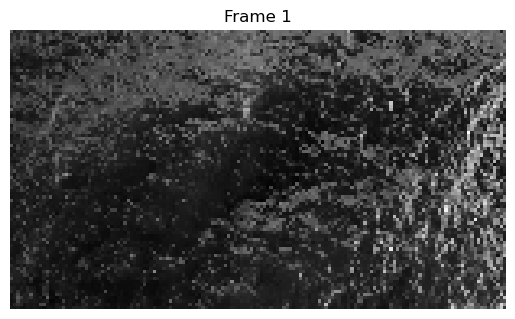

In [9]:
import matplotlib.pyplot as plt

# Assuming processed_frames_array is your array of processed video frames
# Display the first frame
plt.imshow(processed_frames_array[0], cmap='gray')
plt.title('Frame 1')
plt.axis('off')  # Hide the axis to focus on the image
plt.show()

In [10]:
# Assuming shape (frames, H, W)
# Flatten each frame
flattened_frames = processed_frames_array.reshape(processed_frames_array.shape[0], -1)
# Now flattened_frames should have the shape (frames, HW), ready to be fed into the model
# Normalization
flattened_frames = flattened_frames / 255.0

flattened_frames.shape

(711, 13158)

In [11]:
# Calculate the indices for each split
train_end = int(n_frames * 0.6)
validate_end = train_end + int(n_frames * 0.2)
A = train_end
B = validate_end-train_end
print('A = train_end = ', A)
print('B = validate_end = ', B)

# Split the data
train_data = flattened_frames[:train_end]
validate_data = flattened_frames[train_end:validate_end]
test_data = flattened_frames[validate_end:]

# Check the shape of each set
print("Training Data Shape:", train_data.shape)
print("Validation Data Shape:", validate_data.shape)
print("Testing Data Shape:", test_data.shape)


A = train_end =  426
B = validate_end =  142
Training Data Shape: (426, 13158)
Validation Data Shape: (142, 13158)
Testing Data Shape: (143, 13158)


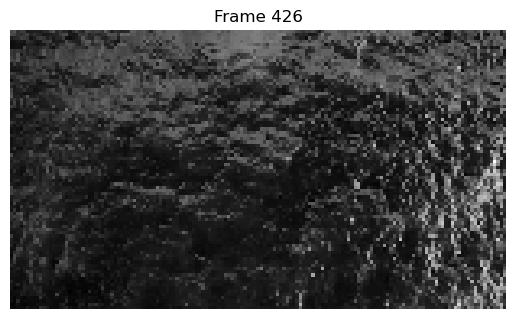

In [12]:
plt.imshow(processed_frames_array[A-1], cmap='gray')
plt.title('Frame '+str(A))
plt.axis('off')  # Hide the axis to focus on the image
plt.show()

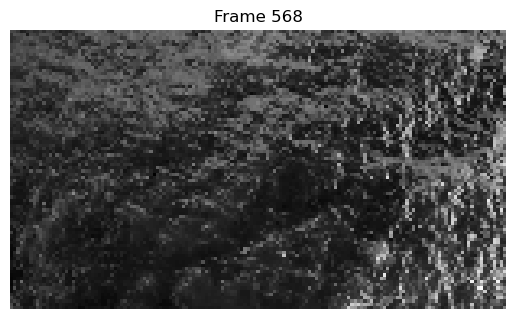

In [13]:
plt.imshow(processed_frames_array[A+B-1], cmap='gray')
plt.title('Frame '+str(A+B))
plt.axis('off')  # Hide the axis to focus on the image
plt.show()

In [14]:
import torch
torch.cuda.empty_cache()
np.random.seed(42)

from SimpleLSTM import *

In [15]:
# Assuming your data is already loaded and normalized in `flattened_frames`
# Reshape data for LSTM: (batch_size, sequence_length, features)
sequence_length = 30
batch_size = 32       # Same as batch_size from Koopman
input_dim = H * W     # Frame size
output_dim = input_dim  # Predicting the next frame

# Split data into sequences
num_sequences = len(train_data) - sequence_length
input_sequences = np.zeros((num_sequences, sequence_length, input_dim))
for i in range(num_sequences):
    input_sequences[i] = train_data[i:i+sequence_length]

# Convert to PyTorch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_sequences = torch.tensor(input_sequences, dtype=torch.float32).to(device)

In [16]:
print('input_sequences.shape = ',input_sequences.shape)
print('H * W =',H * W)
print('n_frames-sequence_length',n_frames-sequence_length)

input_sequences.shape =  torch.Size([396, 30, 13158])
H * W = 13158
n_frames-sequence_length 681


In [17]:
# Split data into sequences
num_sequences = len(validate_data) - sequence_length
input_sequences_val = np.zeros((num_sequences, sequence_length, input_dim))
for i in range(num_sequences):
    input_sequences_val[i] = validate_data[i:i+sequence_length]

# Convert to PyTorch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_sequences_val = torch.tensor(input_sequences_val, dtype=torch.float32).to(device)

In [18]:
# Split data into sequences
num_sequences = len(test_data) - sequence_length
input_sequences_test = np.zeros((num_sequences, sequence_length, input_dim))
for i in range(num_sequences):
    input_sequences_test[i] = test_data[i:i+sequence_length]

# Convert to PyTorch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_sequences_test = torch.tensor(input_sequences_test, dtype=torch.float32).to(device)

Epoch 0/1000 - Loss: 0.22035748 - Val Loss: 0.21847644
Epoch 10/1000 - Loss: 0.16367416 - Val Loss: 0.15531434
Epoch 20/1000 - Loss: 0.05152731 - Val Loss: 0.04805368
Epoch 30/1000 - Loss: 0.01337366 - Val Loss: 0.01217207
Epoch 40/1000 - Loss: 0.00582886 - Val Loss: 0.00591692
Epoch 50/1000 - Loss: 0.00482806 - Val Loss: 0.00478518
Epoch 60/1000 - Loss: 0.00382201 - Val Loss: 0.00387701
Epoch 70/1000 - Loss: 0.00362484 - Val Loss: 0.00371757
Epoch 80/1000 - Loss: 0.00353605 - Val Loss: 0.00362349
Epoch 90/1000 - Loss: 0.00350361 - Val Loss: 0.00360372
Epoch 100/1000 - Loss: 0.00349277 - Val Loss: 0.00358978
Epoch 110/1000 - Loss: 0.00348879 - Val Loss: 0.00358847
Epoch 120/1000 - Loss: 0.00348739 - Val Loss: 0.00358549
Epoch 130/1000 - Loss: 0.00348687 - Val Loss: 0.00358604
Epoch 140/1000 - Loss: 0.00348669 - Val Loss: 0.00358546
Epoch 150/1000 - Loss: 0.00348663 - Val Loss: 0.00358551
Epoch 160/1000 - Loss: 0.00348660 - Val Loss: 0.00358548
Epoch 170/1000 - Loss: 0.00348660 - Val Lo

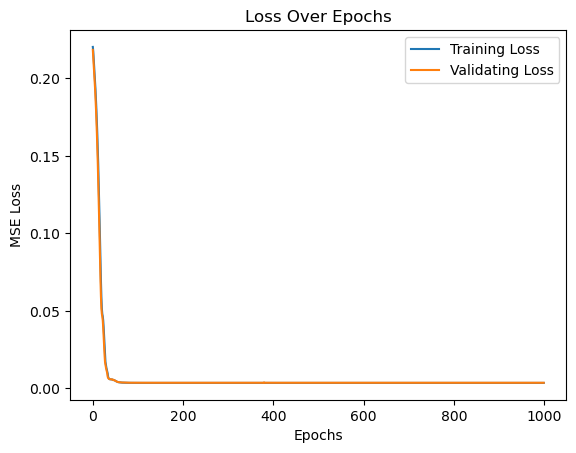

In [19]:
# Define model, loss, and optimizer
hidden_dim = 2**6  # Number of hidden nodes
layer_dim = 2     # Number of LSTM layers
model = SimpleLSTM(input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=output_dim, device=device)
criterion = torch.nn.MSELoss() #MSE loss = F.mse_loss(outputs, targets)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
train_losses = []
valid_lossed = []
num_epochs = 1000
for epoch in range(num_epochs):  # Adjust number of epochs
    model.train()
    optimizer.zero_grad()
    outputs = model(input_sequences)
    loss = criterion(outputs, input_sequences[:, -1, :])  # Predict the last frame in each sequence
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    # Validation step
    model.eval()
    with torch.no_grad():
        val_outputs = model(input_sequences_val)
        val_loss = criterion(val_outputs, input_sequences_val[:, -1, :])
        valid_lossed.append(val_loss.item())
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs} - Loss: {loss.item():.8f} - Val Loss: {val_loss.item():.8f}')

# Plotting training loss
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_lossed, label='Validating Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

In [20]:
print('outputs.shape = ',outputs.shape)

outputs.shape =  torch.Size([396, 13158])


predicted_frames.shape (681, 86, 153)


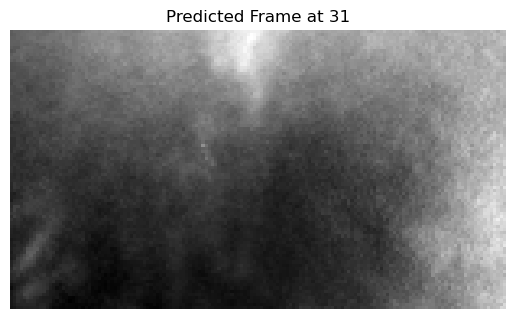

In [21]:
# Assuming the model is already trained and evaluated as before
model.eval()

# Initial sequence for prediction - typically the last sequence from the training data
# Ensure it's on the correct device
#initial_sequence = input_sequences[-1].unsqueeze(0).to(device)
initial_sequence = input_sequences[0].unsqueeze(0).to(device)

# Prepare to collect predictions
predictions = []

# Predict B frames
#for _ in range(B):
for _ in range(n_frames-sequence_length):
    # Generate the next frame prediction
    with torch.no_grad():
        next_frame = model(initial_sequence)
    
    # Prepare the predicted frame to be the next input
    next_frame = next_frame.unsqueeze(0)  # Add batch dimension if needed
    predictions.append(next_frame.cpu().numpy() * 255.0)  # Store the prediction

    # Update the initial sequence by sliding the window: discard the oldest frame, append the new prediction
    initial_sequence = torch.cat((initial_sequence[:, 1:, :], next_frame), dim=1)

# Convert predictions to a proper format
predicted_frames = np.concatenate(predictions, axis=0).reshape(-1, H, W)
print('predicted_frames.shape',predicted_frames.shape)

# Display the first of the predicted frames
first_predicted_frame = predicted_frames[0]
plt.imshow(first_predicted_frame, cmap='gray')
#plt.title(f'Predicted Frame at {A + 1}')
plt.title(f'Predicted Frame at {sequence_length+1}')
plt.axis('off')
plt.show()

In [22]:
len(train_losses)

1000

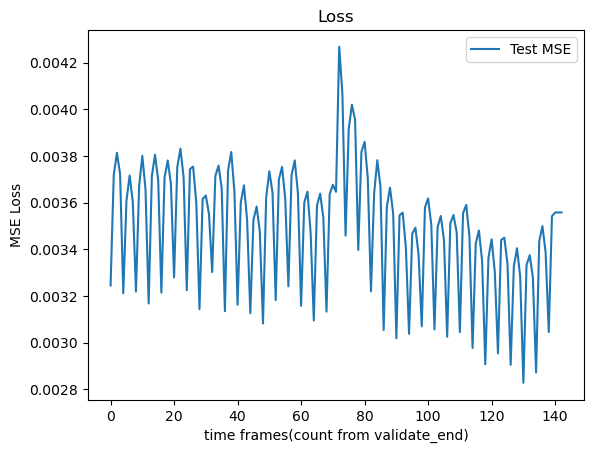

In [23]:
predicted_frames_1D = np.concatenate(predictions, axis=0).reshape(-1, H*W)
predicted_frames_1D = predicted_frames_1D/255.0
#compute Test loss
test_mse = np.mean((predicted_frames_1D[validate_end-sequence_length:]-test_data)**2, axis=1)

# Plotting loss
plt.plot(test_mse, label='Test MSE')
plt.xlabel('time frames(count from validate_end)')
plt.ylabel('MSE Loss')
plt.title('Loss')
plt.legend()
plt.show()


full_predicted_frames.shape (711, 86, 153)


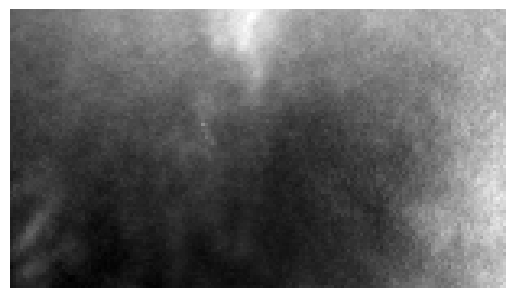

In [24]:
# Animation of predicted frames
from matplotlib.animation import FuncAnimation

def update_frame(i, frames, plot):
    plot.set_data(frames[i])
    return plot,
# Ensure the predicted frame is reshaped to the original dimensions of the image
predicted_frames_2d = predicted_frames.reshape(-1, H, W)
####################################
# Create blank frames
blank_frames = np.zeros((sequence_length, H, W))

# Combine blank frames with the predicted frames
full_predicted_frames = np.concatenate((blank_frames, predicted_frames_2d), axis=0)
print('full_predicted_frames.shape',full_predicted_frames.shape)
####################################

fig, ax = plt.subplots()
plot = ax.imshow(full_predicted_frames[sequence_length+1], cmap='gray', animated=True)
plt.axis('off')

ani = FuncAnimation(fig, update_frame, frames=len(full_predicted_frames), fargs=(full_predicted_frames, plot), blit=True, interval=fps)
ani.save('animation_lstm.mp4')
plt.show()


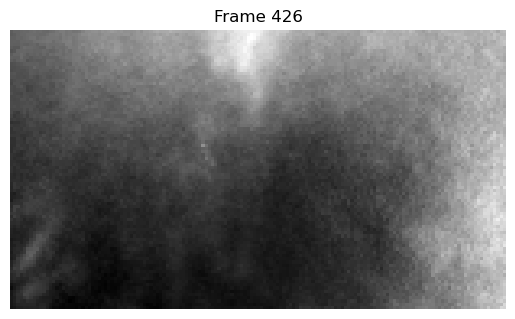

In [25]:
plt.imshow(full_predicted_frames[A-1], cmap='gray')
plt.title('Frame '+str(A))
plt.axis('off')  # Hide the axis to focus on the image
plt.show()

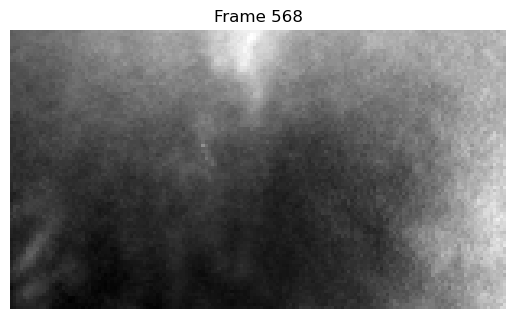

In [26]:
plt.imshow(full_predicted_frames[A+B-1], cmap='gray')
plt.title('Frame '+str(A+B))
plt.axis('off')  # Hide the axis to focus on the image
plt.show()